In [2]:
import pandas as pd
from functions import *

from os import listdir

import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# Data

## Category and uniq_id

In [3]:
df = pd.read_csv("/Users/mikae/OneDrive/Documents/Formation/Data Scientist/Projet_6/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [4]:
cols = ["uniq_id", "product_name", "product_category_tree"]
df = df[cols]

Récupération de la catégorie principale

In [5]:
df = all_categories(df, "product_category_tree", 1, df)

In [6]:
df = df[["uniq_id","categ_0"]]

In [7]:
df.head()

uniq_id          categ_0
0  55b85ea15a1536d46b7190ad6fff8ce7  home furnishing
1  7b72c92c2f6c40268628ec5f14c6d590        baby care
2  64d5d4a258243731dc7bbb1eef49ad74        baby care
3  d4684dcdc759dd9cdf41504698d737d8  home furnishing
4  6325b6870c54cd47be6ebfbffa620ec7  home furnishing

## Image file

In [8]:
path = "/Users/mikae/OneDrive/Documents/Formation/Data Scientist/Projet_6/FlipKart/Images/"
list_images = [file for file in listdir(path)]
print(len(list_images))

1050


In [9]:
data = pd.DataFrame()
data["image_path"] = list_images

In [10]:
def get_unique_id(string):
    split_string = string.split(".")
    substring = split_string[0]
    return substring

In [11]:
data["uniq_id"] = data["image_path"].apply(get_unique_id)

In [12]:
data

image_path                           uniq_id
0     009099b1f6e1e8f893ec29a7023153c4.jpg  009099b1f6e1e8f893ec29a7023153c4
1     0096e89cc25a8b96fb9808716406fe94.jpg  0096e89cc25a8b96fb9808716406fe94
2     00cbbc837d340fa163d11e169fbdb952.jpg  00cbbc837d340fa163d11e169fbdb952
3     00d84a518e0550612fcfcba3b02b6255.jpg  00d84a518e0550612fcfcba3b02b6255
4     00e966a5049a262cfc72e6bbf68b80e7.jpg  00e966a5049a262cfc72e6bbf68b80e7
...                                    ...                               ...
1045  feefbdff924dd6b7cc266449c9a36d69.jpg  feefbdff924dd6b7cc266449c9a36d69
1046  ff24511994fc459d04145231c8876d6c.jpg  ff24511994fc459d04145231c8876d6c
1047  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg  ffbf3794aa8cb6bb8d3f313d0a549a09
1048  ffc2e1fc7c886ec09a331040ada038aa.jpg  ffc2e1fc7c886ec09a331040ada038aa
1049  fffa2117a4006d4a848eb7d5b80d4816.jpg  fffa2117a4006d4a848eb7d5b80d4816

[1050 rows x 2 columns]

## Merge

In [13]:
from sklearn import preprocessing


In [14]:
df_image = pd.merge(data, df)
le = preprocessing.LabelEncoder()
df_image["category"] = le.fit_transform(df_image["categ_0"])

In [15]:
list_categ = df_image["categ_0"].unique().tolist()

In [16]:
list_categ

['watches',
 'kitchen dining',
 'home furnishing',
 'beauty and personal care',
 'computers',
 'home decor festive needs',
 'baby care']

Exemples d'images par catégories

watches


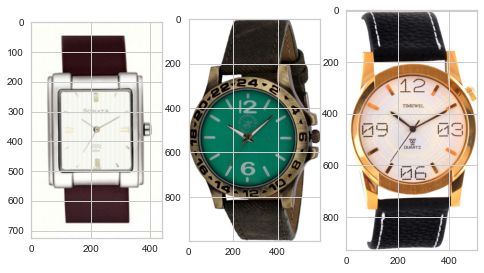

kitchen dining


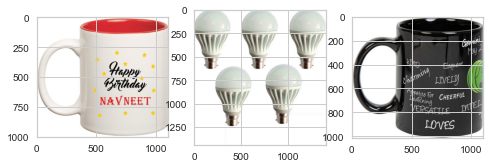

home furnishing


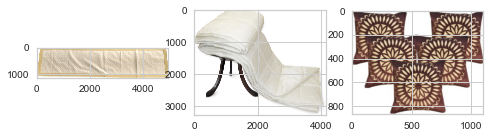

beauty and personal care


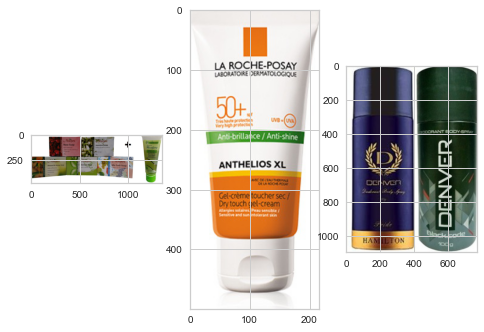

computers


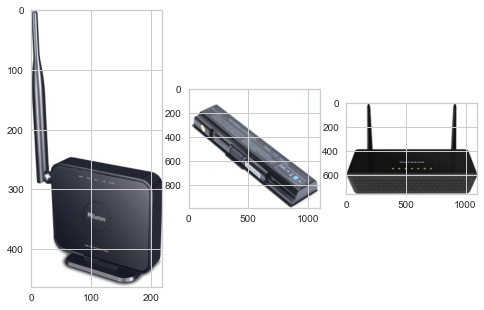

home decor festive needs


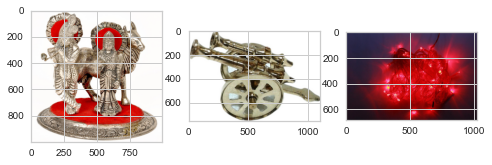

baby care


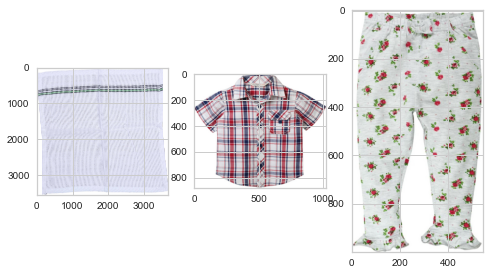

In [17]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [list_images[i] for i in range(len(data)) if df_image["categ_0"][i]==name]
    return list_image_name


for name in list_categ :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# SIFT

## Détermination et affichage des descripteurs SIFT

* L'image contient 5301 descripteurs
* Chaque descripteur est un vecteur de longueur 128

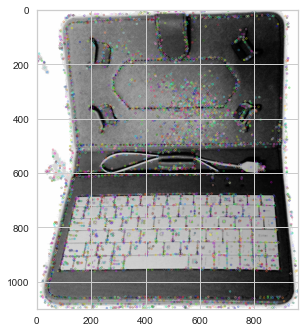

Descripteurs :  (5301, 128)

[[ 21.   0.   0. ...   0.   1.   0.]
 [ 30.   8.   0. ...   0.   0.   2.]
 [  0.   0.   0. ... 132.  16.  11.]
 ...
 [  0.   0.   0. ...   3.   0.   2.]
 [  0.   0.   2. ...  14.   0.   1.]
 [138.   3.   0. ...   0.   0.   1.]]


In [18]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_images[4],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


## Pré-traitement des images via SIFT

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [19]:
img = cv2.imread(path+list_images[15],0)
img

array([[215, 214, 213, ..., 154, 156, 157],
       [213, 212, 211, ..., 150, 153, 154],
       [211, 210, 208, ..., 146, 150, 152],
       ...,
       [234, 233, 233, ..., 225, 226, 226],
       [234, 234, 233, ..., 226, 227, 227],
       [234, 234, 234, ..., 227, 227, 227]], dtype=uint8)

In [20]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_images)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_images[image_num],0)# convert in gray
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype = object)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           226.71 secondes


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [21]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :             5.61 secondes


### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [22]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            37.67 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [23]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [24]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000,
                     init='random', random_state=6,
                    learning_rate = 'auto')
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_image["categ_0"]
print(df_tsne.shape)


(1050, 3)


In [25]:
df_tsne

tsne1      tsne2                     class
0     13.048994  -9.646147                   watches
1    -26.476477 -13.425797            kitchen dining
2     28.627420 -11.874912           home furnishing
3    -13.090132 -11.222003  beauty and personal care
4     14.066333  25.975876                 computers
...         ...        ...                       ...
1045  -7.239715  -0.880405            kitchen dining
1046 -11.793771 -12.481723           home furnishing
1047  -2.090577 -26.418430            kitchen dining
1048  11.280521  11.065641           home furnishing
1049 -15.690105 -14.622587                 computers

[1050 rows x 3 columns]

## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories ne sont pas vraiment séparées

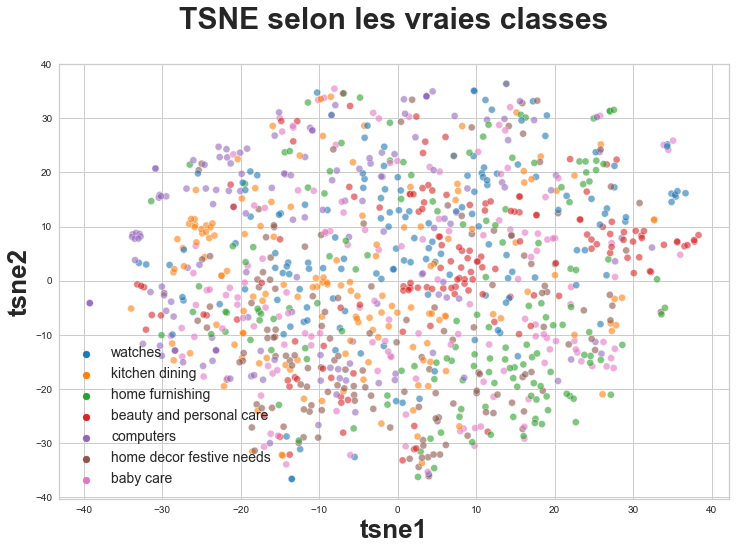

In [26]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

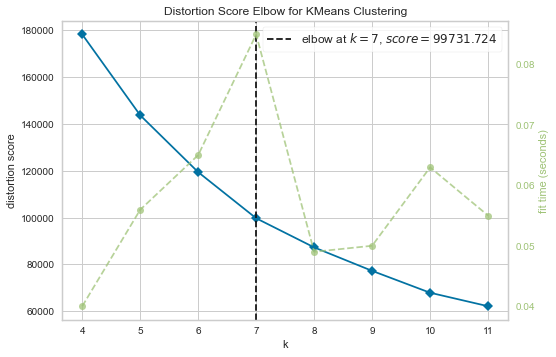

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X_tsne)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [28]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

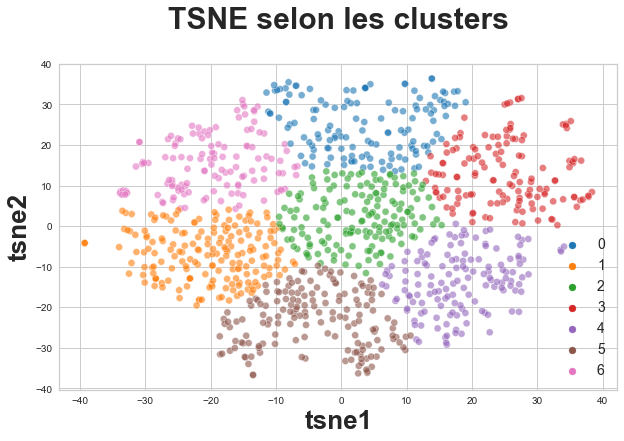

ARI :  0.04578268904529593


In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_image["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes


In [30]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    138
1    182
2    163
3    137
4    142
5    163
6    125
Name: class, dtype: int64

<AxesSubplot:>

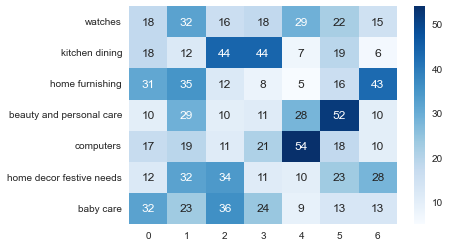

In [31]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categ],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

<AxesSubplot:>

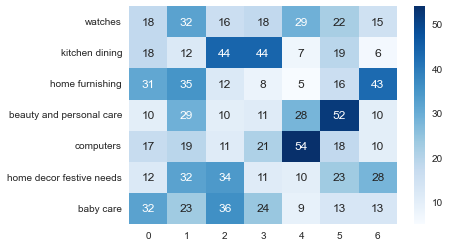

In [32]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categ],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# ORB

In [33]:
orb = cv2.ORB_create(10000)


In [34]:
orb_keypoints = []
temps1=time.time()
orb = cv2.xfeatures2d.BEBLID_create(0.75)
for image_num in range(len(list_images)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_images[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.compute(res, kp)
    orb_keypoints.append(des)
    
orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (526050, 64)
temps de traitement ORB descriptor :            11.32 secondes


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [35]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  725
Création de 725 clusters de descripteurs ...
temps de traitement kmeans :             2.57 secondes


In [36]:
orb_keypoints_by_img.shape

(1050, 501, 64)

### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [37]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            38.11 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [38]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 725)
Dimensions dataset après réduction PCA :  (1050, 45)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [39]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000,
                     init='random', random_state=6,
                    learning_rate = 'auto')
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_image["categ_0"]
print(df_tsne.shape)


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories ne sont pas vraiment séparées

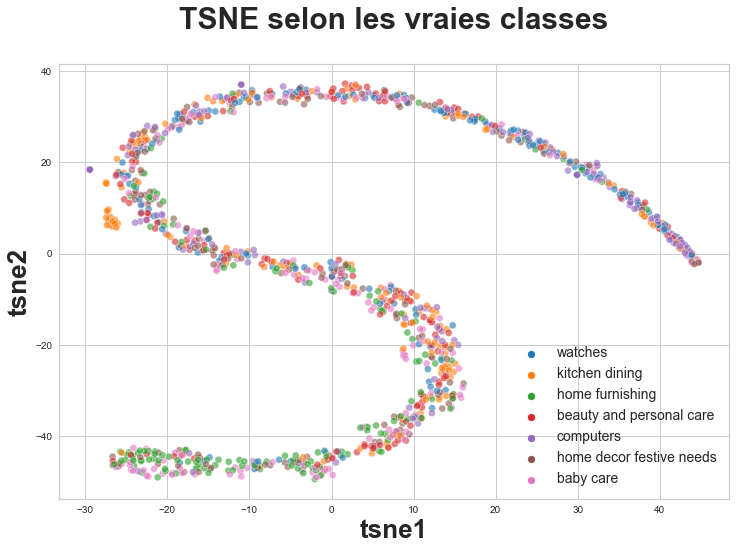

In [40]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

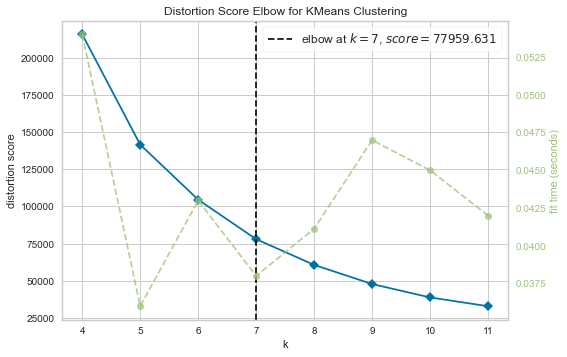

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X_tsne)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [44]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

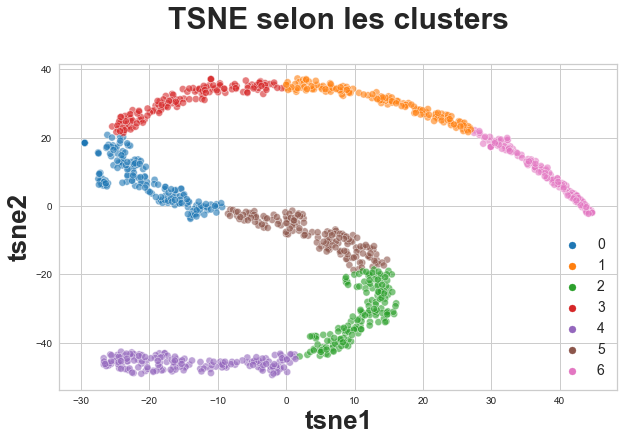

ARI :  0.046448853203555567


In [45]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_image["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes


In [46]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    168
1    136
2    160
3    141
4    167
5    152
6    126
Name: class, dtype: int64

<AxesSubplot:>

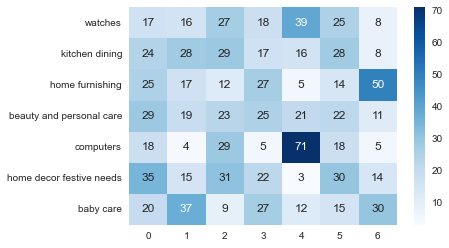

In [47]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categ],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# CNN

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Séparation des images pour avoir un group test

In [13]:
import splitfolders


splitfolders.ratio("Flipkart/", output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 1050 files [00:01, 858.54 files/s]


## Configuration des paramètres principaux du modèle

In [51]:

# Le chemin vers la sauvegarde du réseau
model_savepath    = 'cnn_vgg16_model_trained_2.h5'     

# Les chemins vers les jeu de données
TRAINING_DIR      = "/Users/mikae/OneDrive/Documents/Formation/Data Scientist/Projet_6/output/train/Images/"
TESTING_DIR       = "/Users/mikae/OneDrive/Documents/Formation/Data Scientist/Projet_6/output/val/Images"
IMGSIZE       = 224    # Taille de l'image en input
EPOCH         = 25     # nombre d'epoch 
BATCH_SIZE    = 16     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 15     # pour un VGG16 freeze de réapprentissage de certaines couches
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

##  Constitution des jeux de données


In [52]:
# -------
#  Jeu d'entrainement
# -------

# Dataframe de deux colonnes contenant les id des fichiers et leur label
train_files = listdir(TRAINING_DIR)
id_img = []

for file in train_files:
    id_img.append(file.split(".")[0])

df_train = pd.DataFrame({"id": train_files, "uniq_id": id_img})

In [53]:
df_train = pd.merge(df_train, df[["uniq_id","categ_0"]])
df_train = df_train[["id","categ_0"]]

In [19]:
# Image generator: attention il est préférable de ne pas utiliser d'augmentation de données
# Nous utilisons également un processing spécifique au VGG16 et non pas un rescale 1./255
train_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0.20)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='categ_0',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='training',
            class_mode='categorical')

train_labels = to_categorical(train_generator.classes)

Found 802 validated image filenames belonging to 7 classes.


In [20]:
# -------
#  Jeu de validation
# -------

valid_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='categ_0',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='validation',
            class_mode='categorical')

Found 200 validated image filenames belonging to 7 classes.


In [129]:
# -------
# Jeu de test
# -------

test_files = listdir(TESTING_DIR)
df_test = pd.DataFrame({"id": test_files, 'label': 'nan'})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)    
test_generator = \
    test_datagen.flow_from_dataframe(
        df_test, 
        TESTING_DIR, 
        x_col='id',
        y_col=None, 
        target_size=(IMGSIZE, IMGSIZE), 
        class_mode=None, 
        seed=42,
        batch_size=1, 
        shuffle=False
    )

Found 372 validated image filenames.


## Création du modèle

In [23]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [24]:
# Classifier
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dropout(0.3)(x)

# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(7, activation='softmax', name='softmax')(x)

In [25]:
# Assemblage du modèle final
net_final = Model(inputs=base_model.input, outputs=output_layer)

# freeze de certains layers (spécifique au modèle utilisé)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
    
# Entrainement des derniers layers de classification
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# compilation du modele
net_final.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST  = test_generator.n  // test_generator.batch_size

## Entraînement du modèle

In [31]:
if (TRAIN):
    
    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    checkpoint = ModelCheckpoint("model_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
    #   pour arrêt prématuré
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    # Entrainement du modèle
    history = net_final.fit(
                    train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [checkpoint, early],
                    epochs = EPOCH)
    
    # Sauvegarde du réseau après entrainement
    net_final.save(model_savepath)    
    
else:
    net_final.load_weights('../input/cnn-vgg16-model-trained-2/cnn_vgg16_model_trained_2/'+model_savepath)  

Epoch 1/25
37/50 [=====================>........] - ETA: 2s - loss: 15.7675 - accuracy: 0.1661

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


50/50 [==============================] - ETA: 0s - loss: 14.0132 - accuracy: 0.1870
Epoch 1: val_loss improved from inf to 3.47964, saving model to model_1.h5
50/50 [==============================] - 23s 282ms/step - loss: 14.0132 - accuracy: 0.1870 - val_loss: 3.4796 - val_accuracy: 0.3177
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 6.3787 - accuracy: 0.2532
Epoch 2: val_loss improved from 3.47964 to 2.24859, saving model to model_1.h5
50/50 [==============================] - 13s 262ms/step - loss: 6.3787 - accuracy: 0.2532 - val_loss: 2.2486 - val_accuracy: 0.3854
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 4.0774 - accuracy: 0.3066
Epoch 3: val_loss improved from 2.24859 to 1.91537, saving model to model_1.h5
50/50 [==============================] - 13s 263ms/step - loss: 4.0774 - accuracy: 0.3066 - val_loss: 1.9154 - val_accuracy: 0.3698
Epoch 4/25
50/50 [==============================] - ETA: 0s - loss: 3.2937 - accuracy: 0.2837
Epoc

In [32]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


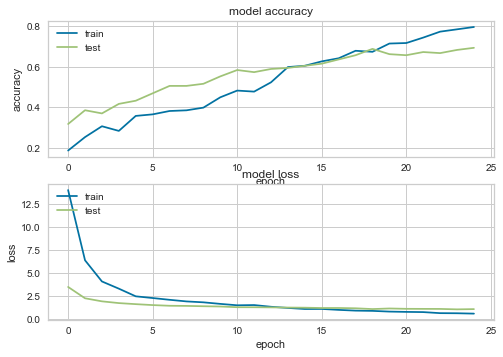

In [33]:
# --------------------------------------
# Affichage des courbes accuracy et Loss
# --------------------------------------
if (TRAIN):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

## Evaluation et prédictions

In [34]:
# Evaluation du modèle
(eval_loss, eval_accuracy) = net_final.evaluate(valid_generator, steps=STEP_SIZE_TEST)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

372/372 [==============================] - 6s 15ms/step - loss: 1.0540 - accuracy: 0.7000
[INFO] accuracy: 70.00%
[INFO] Loss: 1.0540059804916382


In [78]:
# Affichage des classes du jeu d'entrainement
train_generator.class_indices

{'baby care': 0,
 'beauty and personal care': 1,
 'computers': 2,
 'home decor festive needs': 3,
 'home furnishing': 4,
 'kitchen dining': 5,
 'watches': 6}

In [79]:
dict_categ = {}
for k, v in train_generator.class_indices.items():
    dict_categ[v] = k

In [80]:
# Génération des prédictions
test_generator.reset()
pred = net_final.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

372/372 [==============================] - 6s 16ms/step


In [136]:
df_test

id label  \
0    009099b1f6e1e8f893ec29a7023153c4.jpg   nan   
1    00d84a518e0550612fcfcba3b02b6255.jpg   nan   
2    02a53d335775b652f22f41b529b9d646.jpg   nan   
3    02c63a087b298ec74042d557acf61be1.jpg   nan   
4    031c98cfde349d99fb6d5983f54c8751.jpg   nan   
..                                    ...   ...   
367  fc9a650d545a50c72556bed0df59efa1.jpg   nan   
368  fd10586bf7f01bc57e0c5364d4b2c3f7.jpg   nan   
369  fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg   nan   
370  fd53c8ed19e77c3e65d767e6aee5fad7.jpg   nan   
371  fda0890dba67c93a7c80b0993651caec.jpg   nan   

                                                  pred  label_pred  \
0    [0.0028360472060739994, 0.003739682026207447, ...           6   
1    [0.017891408875584602, 0.9297385811805725, 0.0...           1   
2    [0.42918145656585693, 0.0731872171163559, 0.33...           0   
3    [0.02270275168120861, 0.05079054832458496, 0.7...           2   
4    [0.021602913737297058, 0.022787095978856087, 0...           2   
..                                                 ...         ...   
367  [0.07968045026063919, 0.024477848783135414, 0....           2   
368  [0.053253911435604095, 0.12346620112657547, 0....           2   
369  [0.0008232041145674884, 0.00033966920454986393...           2   
370  [0.027839738875627518, 0.05452173948287964, 0....           2   
371  [0.7775259017944336, 0.026490869000554085, 0.0...           0   

                               image_path  category                categ_pred  \
0    009099b1f6e1e8f893ec29a7023153c4.jpg         6                   watches   
1    00d84a518e0550612fcfcba3b02b6255.jpg         1  beauty and personal care   
2    02a53d335775b652f22f41b529b9d646.jpg         1                 baby care   
3    02c63a087b298ec74042d557acf61be1.jpg         2                 computers   
4    031c98cfde349d99fb6d5983f54c8751.jpg         2                 computers   
..                                    ...       ...                       ...   
367  fc9a650d545a50c72556bed0df59efa1.jpg         2                 computers   
368  fd10586bf7f01bc57e0c5364d4b2c3f7.jpg         0                 computers   
369  fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg         2                 computers   
370  fd53c8ed19e77c3e65d767e6aee5fad7.jpg         2                 computers   
371  fda0890dba67c93a7c80b0993651caec.jpg         0                 baby care   

                        categ  
0                     watches  
1    beauty and personal care  
2    beauty and personal care  
3                   computers  
4                   computers  
..                        ...  
367                 computers  
368                 baby care  
369                 computers  
370                 computers  
371                 baby care  

[372 rows x 8 columns]

In [130]:
df_test["pred"] = pred.tolist()
df_test["label_pred"] = df_test["pred"].apply(lambda x : x.index(max(x)))

In [131]:
df_test = pd.merge(df_test, df_image[["image_path", "category"]], left_on = "id", right_on = "image_path", how = "left")   

In [132]:
df_test["categ_pred"] = df_test["label_pred"].map(dict_categ)
df_test["categ"] = df_test["category"].map(dict_categ)

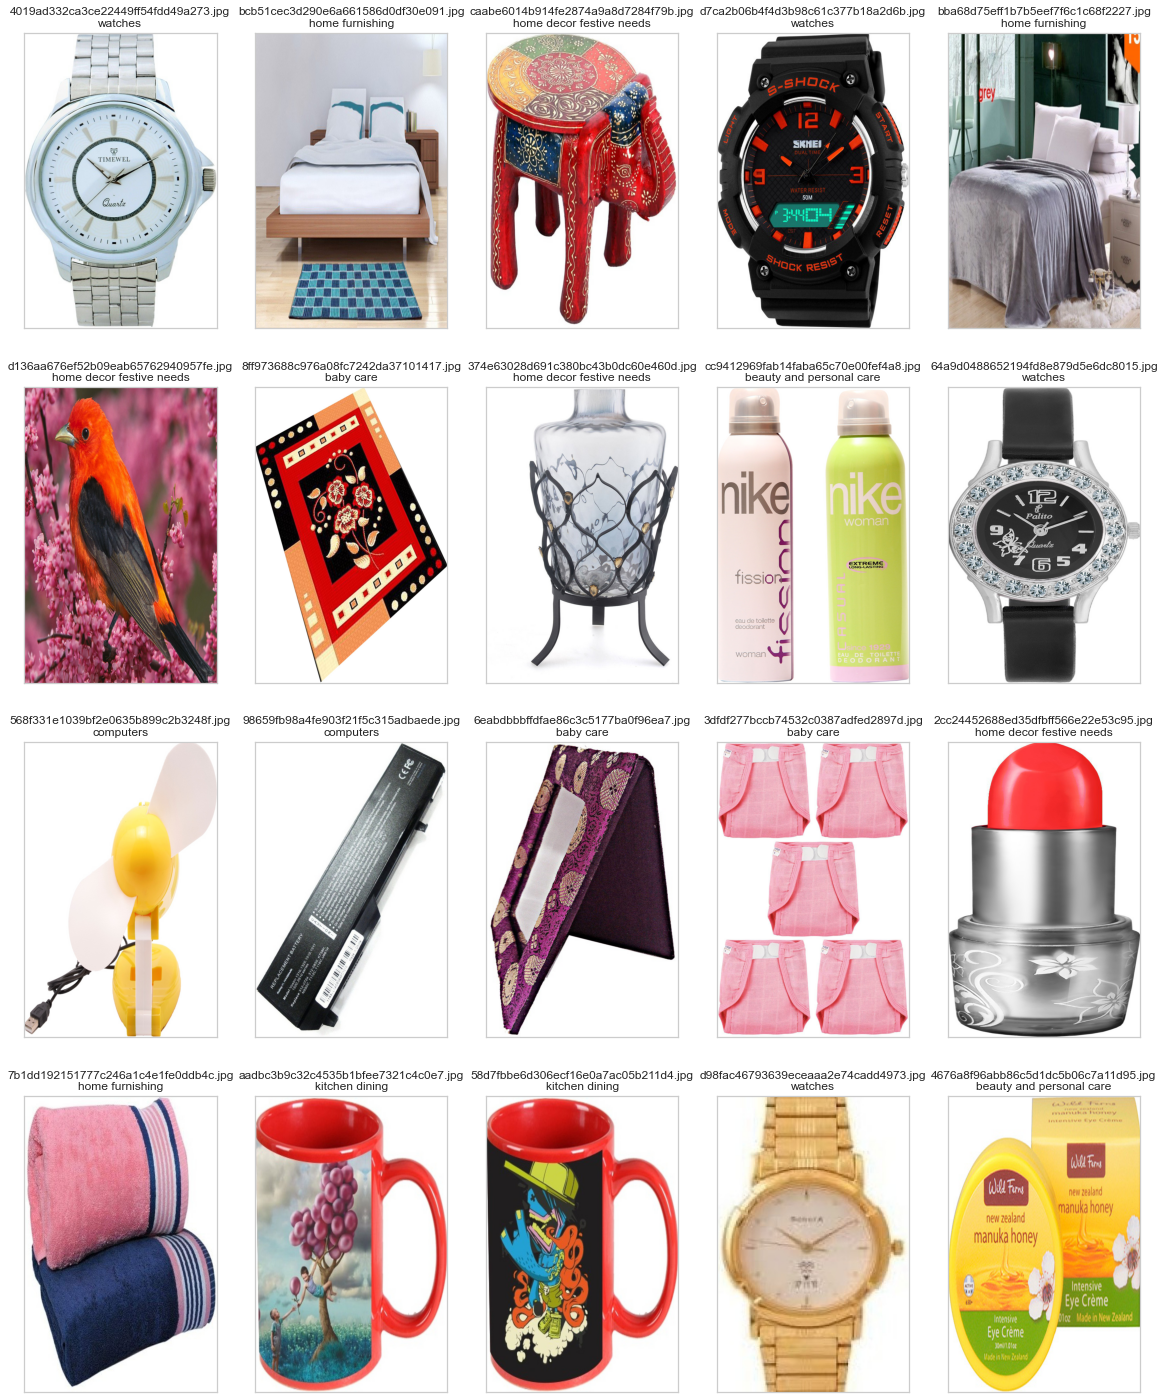

In [90]:
# ---------------------------------------------------------
# Affichage aléatoires images prédites 
# ---------------------------------------------------------
import random

n = df_test.shape[0]
f = list(np.arange(1,n))

c = 20
r =random.sample(f, c)
nrows = 4
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*5, ncols*5))    
for i in range(c):
    file = str(df_test['id'][r[i]])
    path = TESTING_DIR + "/" + file
    img = plt.imread(path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img, aspect='auto')
    plt.xticks([])
    plt.yticks([])
    plt.title(str(df_test['id'][r[i]])+"\n"+str(df_test['categ_pred'][r[i]]))
plt.show()

In [91]:
dict_categ

{0: 'baby care',
 1: 'beauty and personal care',
 2: 'computers',
 3: 'home decor festive needs',
 4: 'home furnishing',
 5: 'kitchen dining',
 6: 'watches'}

<AxesSubplot:>

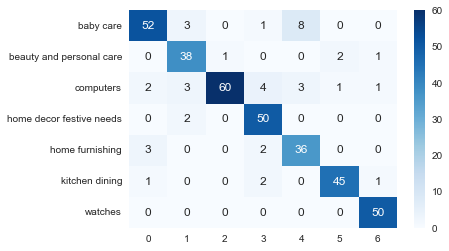

In [137]:
conf_mat = metrics.confusion_matrix(df_test["label_pred"], df_test["category"])

df_cm = pd.DataFrame(conf_mat, index = [v for k, v in dict_categ.items()],
                  columns = [k for k, v in dict_categ.items()])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
print(metrics.classification_report(df_test["label_pred"], df_test["category"]))

In [138]:
ARI = np.round(metrics.adjusted_rand_score(df_test["label_pred"], df_test["category"]),4)
ARI

0.7596

## Représentation

Extraction des features avant la dernière couche dense pour visualisation après une réduction de dimension par TSNE

In [207]:
model2 = Model(inputs=net_final.input, outputs=net_final.layers[-1].output)
features = model2.predict(test_generator)

372/372 [==============================] - 5s 14ms/step


In [2]:
# Function for plotting t-sne result as data points
def visualise_tsne_datapoints(tsne_data, labels):
    
    """Takes in tsne projections, plots distribution of datapoints in 2 classes"""
    
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    plt.figure(figsize=(10,9))
    sns.scatterplot(
    x=tx, y=ty,
    hue=labels,
    palette=dict_color,
    s=50, 
    legend='auto'
    )

In [159]:
dict_color = dict(zip(list_categ, sns.color_palette(palette = "tab10",n_colors = len(list_categ))))

In [154]:
y_val = df_test["categ_pred"]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


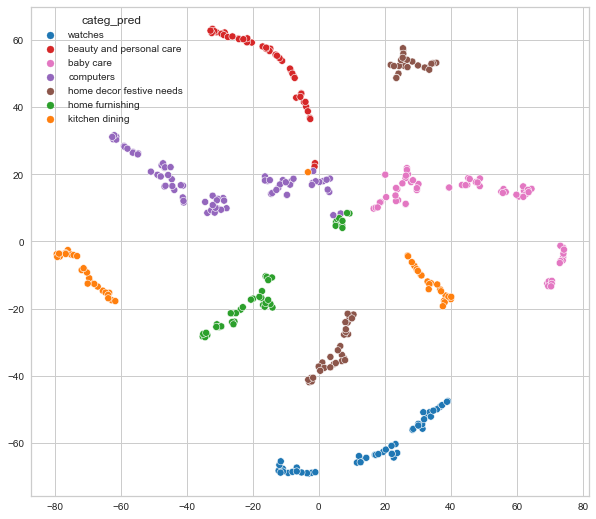

In [213]:
tsne_model = TSNE(random_state=42, perplexity = 5).fit_transform(features)
visualise_tsne_datapoints(tsne_model, y_val)

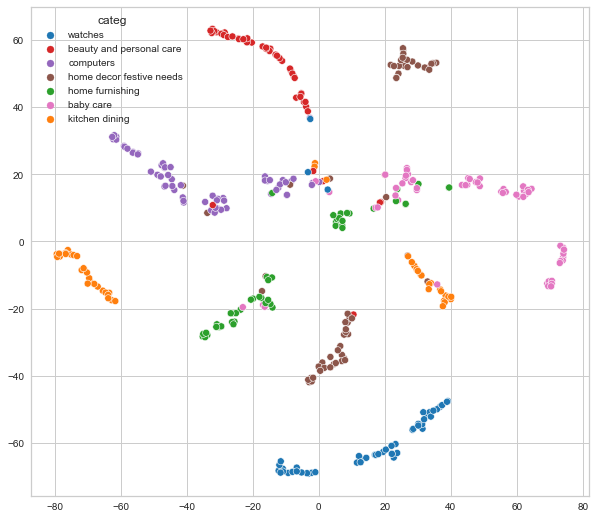

In [214]:
visualise_tsne_datapoints(tsne_model, df_test["categ"])